---
title: phase_and_hilbert_transform.ipynb
description: ''
date: '2022-05-12T17:02:23.141Z'
name: phaseandhilbert
oxa: oxa:RkW3EUemHJbWfgejvqYu/mNnJgVOim6kyzo1p5ipL
---

# Phase and the Hilbert Transform

The first verision of this tutorial was published in 2014 in [The Leading Edge](https://library.seg.org/doi/10.1190/tle33101164.1) where GNU Octave was used for coding and plotting.

A python version is long overdue and thank's to the notebook we can now bring all the example code inline easily.

## Load Data

We have 2 data files available:

1. `data/penobscot_xl1155.sgy` as single crossline from the Penoscot 3D seismic survey

2. `data/trace_il1190_xl1155.trace` a single trace from that same crossline extracted in OpenDTect

Of course its easy to access any trace in that line directly now with segyio.

In [1]:
import segyio
import numpy as np

with segyio.open('./data/penobscot_xl1155.sgy') as f:
    line = f.xline[1155]
    seismic = line[:, 500:750]
    
    il_idx = np.argwhere(f.ilines == 1190)[0][0]
    trace = line[il_idx,:]
    
    vmin, vmax = np.min(line), np.max(line)
    vrng = max(abs(vmin), vmax)
    
    print(f"trace at inline 1190 is at index {il_idx}")
    print(f"sample range {f.samples[0]}, {f.samples[-1]}")
    print(f"data range {vmin}, {vmax}")

trace at inline 1190 is at index 190
sample range 0.0, 6000.0
data range -19918.0, 25805.0


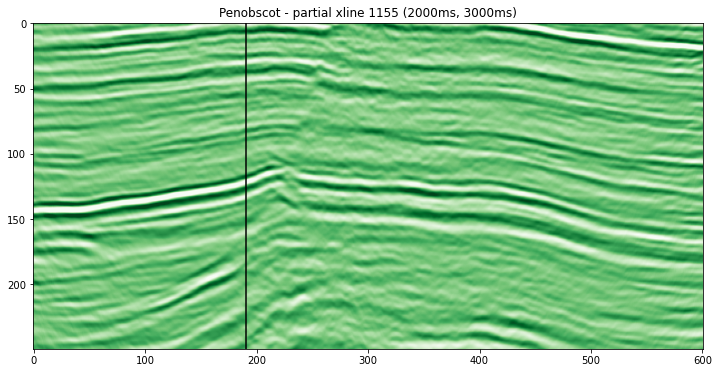

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.imshow(seismic.T, vmin=-vrng/5, vmax=vrng/5, cmap='Greens', aspect='auto')
plt.axvline(il_idx, 0, 250, color='black')
_=plt.title(f"Penobscot - partial xline 1155 ({500*4}ms, {750*4}ms)")

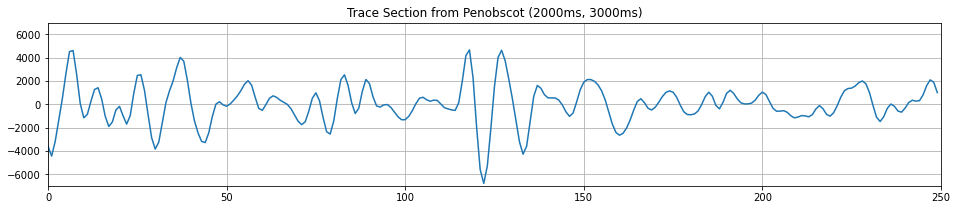

In [3]:
plt.figure(figsize=(16,3))
plt.plot(trace[500:750])
plt.grid('on')
plt.title('Trace Section from Penobscot (2000ms, 3000ms)')
plt.ylim(-7000,7000)
_=plt.xlim(0,250)

## Phase Shifting

Our phase shifting approach works by manipulating the FFT coefficents of the trace.
The code below has been ported from the original Octave code in the TLE version and can be used to produce an arbitrary phase shift.

In [4]:
from math import ceil,exp
from scipy.fftpack import fft, ifft

def fftshifter(x, phase_shift_in_radians):
    # Create an array to apply the coefficient to 
    # positive and negative frequencies appropriately
    N = len(x);
    R0 = np.exp(-1j*phase_shift_in_radians);
    R = np.ones(x.shape, dtype=np.complex);
    R[0]=0.; 
    R[1:N//2] = R0;
    R[N//2:] = np.conj(R0);

    # Apply the phase shift in the frequency domain
    Xshifted = R*fft(x);
    
    # Recover the shifted time domain signal
    y = np.real(ifft(Xshifted));
    
    return y

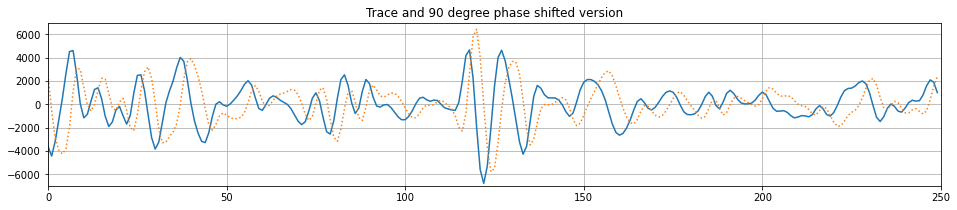

In [5]:
rotation_angle_degrees = 90
yp = fftshifter(trace, np.pi*rotation_angle_degrees/180)

plt.figure(figsize=(16,3))
plt.plot(trace[500:750])
plt.plot(yp[500:750],':')
plt.grid('on')
plt.title(f"Trace and {rotation_angle_degrees} degree phase shifted version")
plt.ylim(-7000,7000)
_=plt.xlim(0,250)

Which can then of course be used to perform a Hilbert Transform y shifting by 90 degrees.

But! of course we are now in python with scipy available and can benefit from a built in hilbert transform functions. Note there are 2!
 - [scipy.signal.hilbert](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html)
 - [scipy.fftpack.hilbert](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.hilbert.html)
 
that have different calling semantics but a hilbert transform is a hilbert transform and below we can see they are equivalent to the `fftshifter` at 90 degrees.

TODO: Currently there are differences, as we are not applying a window to our trace prior to FFT computation in the function above. Needs to be addressed, check the scipy implementations to see what they are using.

## Complex Trace Attributes

Computing the Hilbert Transform allows us to use the Analytic Trace representation

$z = s(t) + i \cdot H(s(t))$

to compute a variety of well known seimsic trace attributes. For example, envelope and instantaneous phase.

In [6]:
from scipy.signal import hilbert as hilbert_transform
hilbert = np.zeros_like(seismic)

for x in range(line.shape[0]):
    hilbert[x,:] = np.imag(hilbert_transform(line[x,:])[500:750])

z = seismic + 1j*hilbert
env = np.abs(z)
phase = np.angle(z)

### On a Trace




(2000.0, 3000.0)

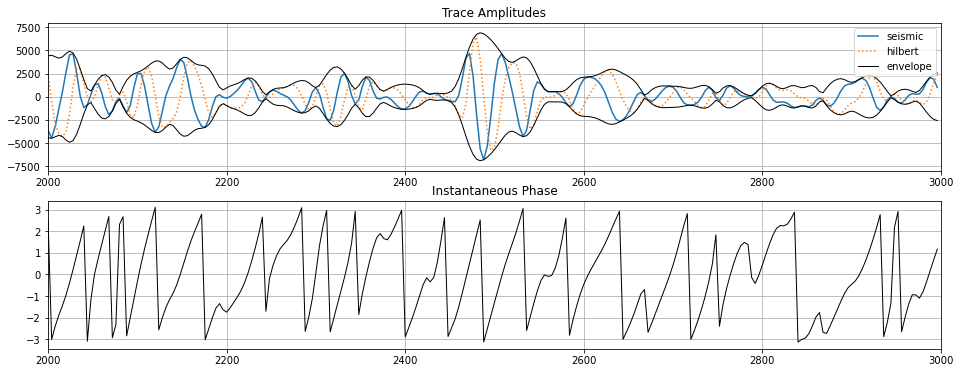

In [7]:
fig, axs = plt.subplots(2,1, figsize=(16,6))

t = np.arange(2000,3000, 4.0)
axs[0].plot(t,seismic[il_idx, :])
axs[0].plot(t, hilbert[il_idx, :], ':')
axs[0].plot(t, env[il_idx, :], 'k', linewidth=1)
axs[0].plot(t, -env[il_idx, :], 'k', linewidth=1)
axs[0].set_title('Trace Amplitudes')
axs[0].grid('on')
axs[0].set_xlim(2000,3000)
axs[0].set_ylim(-8000,8000)
axs[0].legend(labels=['seismic','hilbert','envelope'])


axs[1].plot(t,phase[il_idx, :], 'k', linewidth=1)
axs[1].set_title('Instantaneous Phase')
axs[1].grid('on')
axs[1].set_xlim(2000,3000)

### On a Section

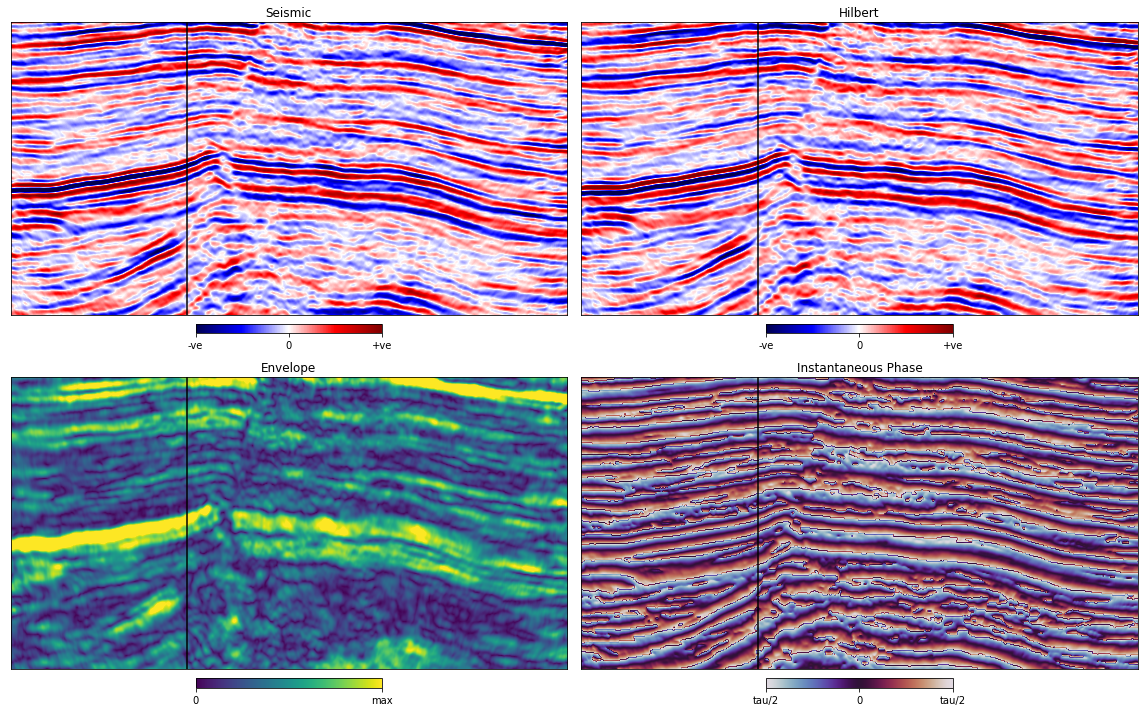

In [53]:
fig, axs = plt.subplots(2,2, figsize=(16,10))

def plot_it(ax, data, vmin, vmax, title, cmap, ticks, ticklabels, alpha=1.0, interpolation='bilinear'):
    im = ax.imshow(data.T, vmin=vmin, vmax=vmax, cmap=cmap, aspect='auto', alpha=alpha, interpolation=interpolation)
    ax.axvline(il_idx, 0, 250, color='black')
    ax.set_title(title)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    cbar = fig.colorbar(im, 
                        ax=ax,
                        ticks=ticks,
                        orientation='horizontal',
                        fraction=0.03, pad=0.03)
    cbar.ax.set_xticklabels(ticklabels)

plot_it(axs[0][0], seismic, -vrng/5, vrng/5, 'Seismic', 'seismic', [-vrng/5, 0, vrng/5], ['-ve', '0', '+ve'])
plot_it(axs[0][1], hilbert, -vrng/5, vrng/5, 'Hilbert', 'seismic', [-vrng/5, 0, vrng/5], ['-ve', '0', '+ve'])
plot_it(axs[1][0], env, 0, vrng/5, 'Envelope', 'viridis', [0, vrng/5], ['0', 'max'])
plot_it(axs[1][1], phase, -np.pi, np.pi, 'Instantaneous Phase', 'twilight', [-np.pi, 0, np.pi], ['tau/2', '0', 'tau/2'])

plt.tight_layout()

## Checking the phase of the seismic

The principle that Roden and Sepúlveda (1999) apply is that at strong reflections in zero-phase data, we would expect peaks (or troughs) in the trace to align with peaks in the envelope. Therefore, any horizon that we pick on zero-phase data could also be picked on the envelope of that data.

We can use this principle to check for residual phase at given reflectors

In [9]:
from math import ceil
from scipy.ndimage.filters import maximum_filter1d
import warnings

def find_peaks(x, a):
    y = np.full(x.shape, np.nan)
    ya = np.full(x.shape, np.nan)
    xmax = maximum_filter1d(x, 3)
    max_mask = x >= xmax
    y[max_mask] = x[max_mask]
    ya[max_mask] = a[max_mask]
    return y, ya

def get_idealised_phase(phase_at_peaks):
    # flip to nearest 'zero' phase point
    ideal_phase = np.full(phase_at_peaks.shape, np.nan);
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ideal_phase[np.abs(phase_at_peaks) < np.pi/2] = 0.;    
        ideal_phase[np.abs(phase_at_peaks - np.pi) < np.pi/2] = np.pi;
        ideal_phase[np.abs(phase_at_peaks + np.pi) < np.pi/2] = -np.pi;
    return ideal_phase

In [10]:
penv, pphase = find_peaks(env[il_idx, :], phase[il_idx, :])
idealised_phase = get_idealised_phase(pphase)

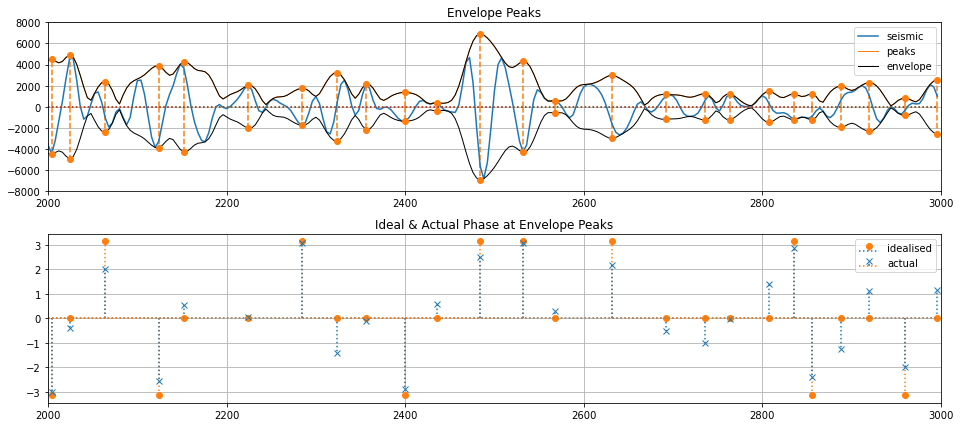

In [11]:
fig, axs = plt.subplots(2,1, figsize=(16,7))

t = np.arange(2000,3000, 4.0)

axs[0].plot(t,seismic[il_idx, :])
axs[0].plot(t,env[il_idx, :], linewidth=1)
axs[0].plot(t,env[il_idx, :],'k', linewidth=1)
axs[0].plot(t,-env[il_idx, :],'k', linewidth=1)
axs[0].stem(t,penv, 'C1--','C1o',':')
axs[0].stem(t,-penv, 'C1--','C1o',':')
axs[0].grid('on')
axs[0].set_xlim(2000,3000)
axs[0].set_ylim(-8000,8000)
axs[0].legend(labels=['seismic','peaks','envelope'])
axs[0].set_title('Envelope Peaks')

axs[1].stem(t, idealised_phase,'C1:','C1o',':')
axs[1].stem(t, pphase,'C0:','C0x',':')
axs[1].grid('on')
axs[1].set_xlim(2000,3000)
axs[1].legend(labels=['idealised','actual'])
axs[1].set_title('Ideal & Actual Phase at Envelope Peaks')

plt.subplots_adjust(hspace=0.25)

## Plot phase error on a section

In [59]:
from tqdm.notebook import tqdm
phase_error = np.zeros_like(seismic)

for x in tqdm(range(line.shape[0])):
    _, pphase = find_peaks(env[x, :], phase[x, :])
    idealised_phase = get_idealised_phase(pphase)
    phase_error[x,:] = np.abs(idealised_phase-pphase)

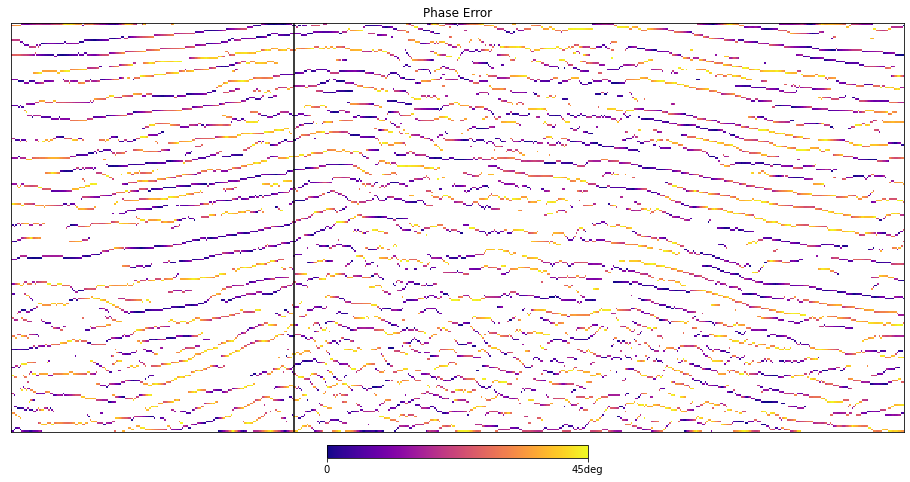

In [63]:
fig, ax = plt.subplots(1,1, figsize=(16,8))

plot_it(ax, phase_error, 0, np.pi/2, 'Phase Error', 'plasma', [0, np.pi/2], ['0', '45deg'], interpolation='none')